In [1]:
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import os
import numpy as np
import pandas as pd
import glob
import math

In [2]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=200)
loc0p4 = plticker.MultipleLocator(base=0.4)

In [3]:
def get_event_info(event_path):
    #print(event_path)
    hits, truth = load_event(event_path, parts=['hits', 'truth'])
    num_tracks = np.unique(truth['particle_id'].values).shape[0] - 1
    total_hits = hits.shape[0]
    num_not_used_hits = truth[truth['particle_id'] == 0].shape[0]
    del hits, truth
    return (num_tracks, total_hits, num_not_used_hits)

In [4]:
train = np.unique([p.split('-')[0] for p in sorted(glob.glob('input/train_1/**'))])

## Explore some event-level information
*  How many hits in each event?
*  How many of them arise from real particles?
*  How many tracks in each event?

In [52]:
training_event_info = list(map(get_event_info, train))

In [56]:
df = pd.DataFrame(data=training_event_info)

In [63]:
df.describe()

,0,1,2
count,1770.000000,1770.000000,1770.000000
mean,9277.931073,109394.628814,17697.974011
std,1079.250283,10668.849851,135.498374
min,5981.000000,77089.000000,17265.000000
25%,8477.000000,101528.250000,17608.000000
50%,9243.000000,109066.000000,17697.000000
75%,10032.000000,116878.750000,17788.000000
max,12551.000000,140699.000000,18131.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaefab5ac8>,
      dtype=object)

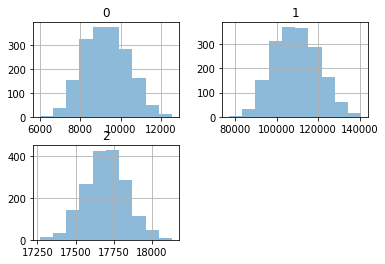

In [61]:
df.hist(alpha=0.5)

## how many real tracks in this event?

In [36]:
num_unknown_particles = all_info[all_info['particle_id'] == 0].shape[0]
num_known_particles = np.unique(all_info['particle_id'].values).shape[0]-1
#total_tracks = num_unknown_particles+num_known_particles
total_tracks = num_known_particles
total_hits = all_info.shape[0]
print("not used hits: {} ({:.2%})".format(num_unknown_particles, num_unknown_particles/total_hits))
print("tracks from real particle:", num_known_particles)
# print("total tracks: ", total_tracks)
print("total hits:", total_hits)
print("averge hits per track: {:.2f}".format(total_hits/total_tracks))

not used hits: 17634 (14.58%)
tracks from real particle: 10565
total hits: 120939
averge hits per track: 11.45


In *particles*, no particle_id == 0

## how many particles does not have a hit in truth level?

In [35]:
num_particles_with_no_hits = particles[particles['nhits'] == 0].shape[0]
total_particles = particles.shape[0]
print("total truth particles:", total_particles)
print("particles without hits: {} ({:.2%})".format(num_particles_with_no_hits, num_particles_with_no_hits/total_particles))
print("particles with hits: {}".format(total_particles-num_particles_with_no_hits))

total truth particles: 12263
particles without hits: 1698 (13.85%)
particles with hits: 10565


## detector information

In [64]:
det = pd.read_csv('input/detectors.csv')
det.head()

,volume_id,layer_id,module_id,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,...,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhu,module_maxhu,module_hv,pitch_u,pitch_v
0,7,2,1,-65.7965,-5.17830,-1502.5,0.078459,-0.996917,0.0,-0.996917,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
1,7,2,2,-139.8510,-6.46568,-1502.0,0.046183,-0.998933,0.0,-0.998933,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
2,7,2,3,-138.6570,-19.34190,-1498.0,0.138156,-0.990410,0.0,-0.990410,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
3,7,2,4,-64.1764,-15.40740,-1498.0,0.233445,-0.972370,0.0,-0.972370,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
4,7,2,5,-136.2810,-32.05310,-1502.0,0.228951,-0.973438,0.0,-0.973438,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625


In [91]:
volume_groups = det.groupby(['volume_id'])
det_data = []
for v in np.unique(det['volume_id']):
    layers = np.unique(volume_groups.get_group(v)['layer_id'])

    layer_groups = det.groupby(['volume_id', 'layer_id'])
    total_modules = 0
    for layer in layers:
        modules = layer_groups.get_group((v,layer))['module_id']
        total_modules += len(modules)
    info = [v, len(layers), total_modules]
    print("volume # {} has {} layers and total {} modules".format(*info))
    det_data.append(info)

volume # 7 has 7 layers and total 756 modules
volume # 8 has 4 layers and total 2492 modules
volume # 9 has 7 layers and total 756 modules
volume # 12 has 6 layers and total 1020 modules
volume # 13 has 4 layers and total 5796 modules
volume # 14 has 6 layers and total 1020 modules
volume # 16 has 6 layers and total 588 modules
volume # 17 has 2 layers and total 5712 modules
volume # 18 has 6 layers and total 588 modules


In [92]:
df_det_data = pd.DataFrame(data=det_data)

In [94]:
print("total {} layers and total {} modules".format(df_det_data[1].sum(), df_det_data[2].sum()))

total 48 layers and total 18728 modules


### Features to use

In [5]:
from utils import plot_detector

In [7]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('input/train_1', event_prefix))
from utils import get_features
hits = get_features(hits)
hits_truth = pd.merge(hits, truth, on=['hit_id'])

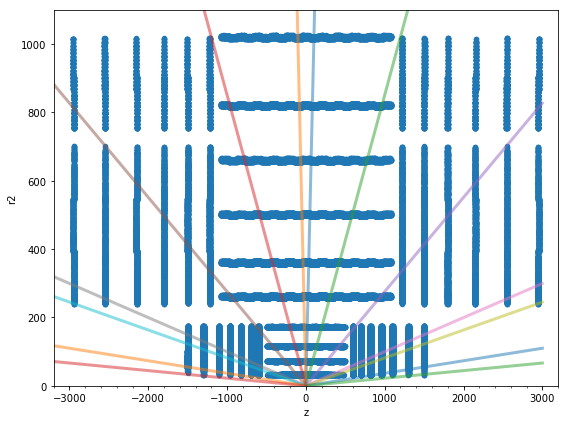

In [7]:
plot_detector(hits)

In [5]:
from utils import view

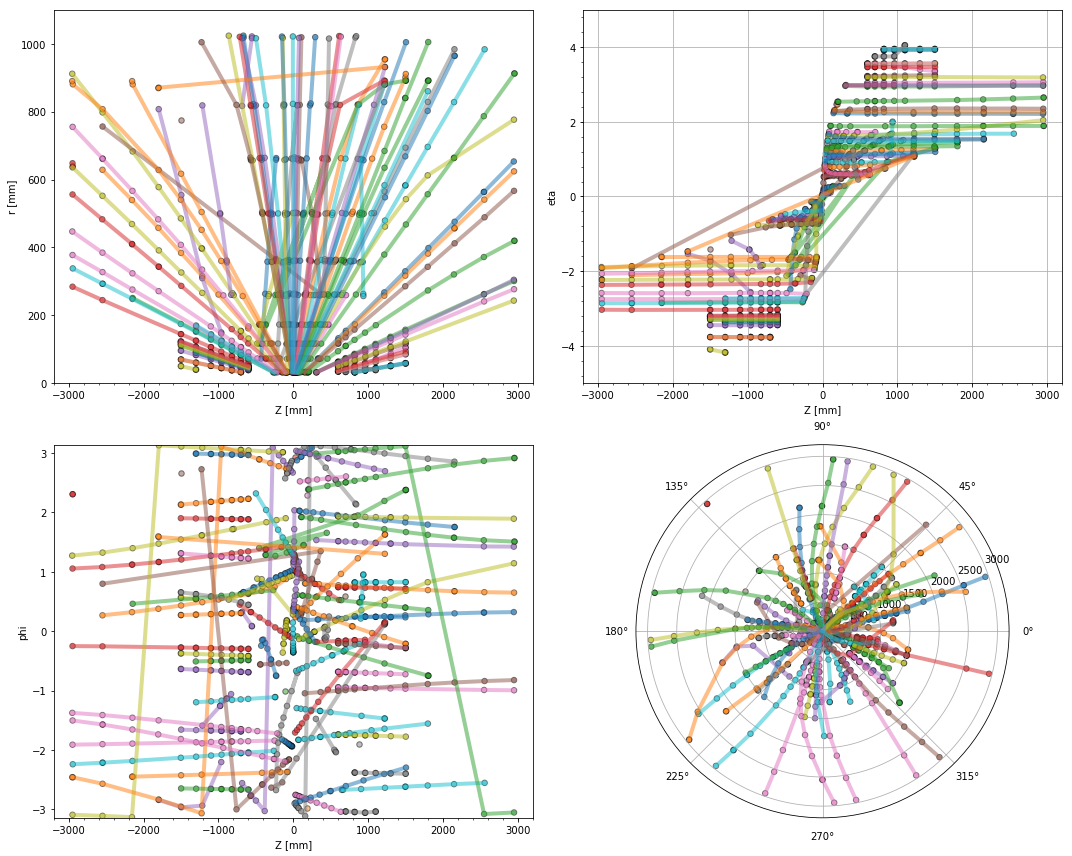

In [8]:
res = view(hits_truth, pd.Series(np.unique(truth['particle_id'])), numb=100, pID_name='particle_id')

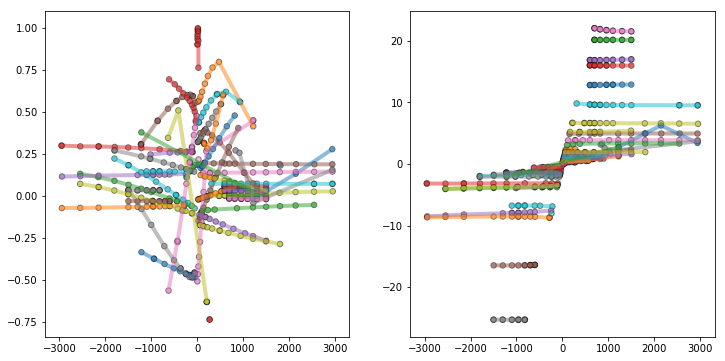

In [9]:
numb = 50
df = hits_truth
pID_name = 'particle_id'
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for p in pd.Series(np.unique(truth[pID_name])).sample(numb):
    data = df[df[pID_name] == p][['r2', 'eta', 'phi', 'z', 'absZ', 'x2', 'y2', 'z1']].sort_values(by=['absZ']).values
    ax1.plot(data[:,3], data[:,5], '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax1.scatter(data[:,3], data[:,5], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)
    
    ax2.plot(data[:,3], data[:,7], '-', alpha=0.5, lw=4, label='{}'.format(p))
    ax2.scatter(data[:,3], data[:,7], marker='o', edgecolor='black', s=np.ones(len(data))*30, alpha=0.5)